# Tiling process

In this notebook I'm going to perform tiling, a step that helps us to crop very small patches out of the full resolution image of the Whole Slide Image (WSI). 
In particular, I'll perform it on the original WSI and on the normalised ones.
The operation itself leverages on the output of the manual image alignment performed thanks to Loupe Browser 8.0® where in the end a table containing the spots coordinates in the grid and in the image, with relative barcodes, is returned.\
The importance of this table will be increase more and more from now on.

Conda environment: `tiling`\
Referring to Visium WSIs and it's relative normalisation outcomes.

# 0. - Loading packages

In [1]:
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.font_manager as fm
%matplotlib inline
import pandas as pd
import os
import subprocess
from PIL import Image, ImageDraw
pd.options.mode.chained_assignment = None
import math

Loading the font.

In [2]:
# Fetch DM Sans font file from https://github.com/google/fonts/blob/main/ofl/dmsans/DMSans%5Bopsz%2Cwght%5D.ttf or, better, https://fonts.google.com/specimen/DM+Sans
font_path = "../fonts/static/DMSans-SemiBold.ttf" 

# Add font to matplotlib
try:
    fm.fontManager.addfont(font_path)
    plt.rcParams['font.family'] = 'DM Sans'
except RuntimeError as e:
    print(f"Failed to load font: {e}")

# 1. - Setting input and output paths

## 1.1 Setting the working paths

In [3]:
os.chdir("/disk2/user/gabgam/work/gigi_env/the_project/1_tiling/")
print(os.getcwd())

# Saving folder for plots
os.makedirs("./figures", exist_ok = True)

/disk2/work/gabgam/gigi_env/the_project/1_tiling


## 1.2 Input, output and checks

First of all, we have to define the path containing the reference coordinate system for spatial-ATAC and all the relative useful files.

In [4]:
# # path to manual alignment .json or the scalefactor .json file -> you can use the both of them, there is no difference.
# VISIUM_ALIGNMENT_JSON_PATH = f'../data/visium_2022_FF_WG/input_files/Visium_Human_Breast_Cancer_alignment_file.json'
# SCALE_FACTOR_PATH = "../data/visium_2022_FF_WG/output_n_suppl_files/spatial/scalefactors_json.json"

# # path to tissue_positions_list.csv
# POSITION_LIST_PATH = "../data/visium_2022_FF_WG/output_n_suppl_files/spatial/tissue_positions_list.csv"
# # from website: Spots detected under tissue - 4,898

# # Full-resolution image location
# IMAGE_PATH = f'../data/visium_2022_FF_WG/input_files/Visium_Human_Breast_Cancer_image.tif'

# # normalised WSIs path
# WSI_NORMALISATION_OUTPUT_PATH = "../0_WSI_alignment_and_normalisation/output/2022_FF_WG_10X/wsi_img_not_changed/"

# #----------------------------------------------
# # This will define all the next saving paths
# SAMPLE = "2022_FF_WG_10X"
# IMAGE_VERSION = "img_not_changed"
# COORDINATE_SYSTEM = "allspots"

# print(f"Sample name: {SAMPLE}\nImage version: {IMAGE_VERSION}\nCoordinate_system: {COORDINATE_SYSTEM}")

In [5]:
# path to manual alignment .json or the scalefactor .json file -> you can use the both of them, there is no difference.
#VISIUM_ALIGNMENT_JSON_PATH = f'../data/visium_2022_FF_WG/input_files/Visium_Human_Breast_Cancer_alignment_file.json'
SCALE_FACTOR_PATH = "../data/visium_ffpe/output_n_suppl_files/spatial/scalefactors_json.json"

# path to tissue_positions_list.csv
POSITION_LIST_PATH = "../data/visium_ffpe/output_n_suppl_files/spatial/tissue_positions_list.csv"
# from website: Spots detected under tissue - 2,518

# Full-resolution image location
IMAGE_PATH = f'../data/visium_ffpe/input_files/Visium_FFPE_Human_Breast_Cancer_image.tif'

# normalised WSIs path
WSI_NORMALISATION_OUTPUT_PATH = "../0_WSI_alignment_and_normalisation/output/FFPE_dcis_idc_10X/wsi_img_not_changed/"

#----------------------------------------------
# This will define all the next saving paths
SAMPLE = "FFPE_dcis_idc_10X"
IMAGE_VERSION = "img_not_changed"
COORDINATE_SYSTEM = "allspots"

print(f"Sample name: {SAMPLE}\nImage version: {IMAGE_VERSION}\nCoordinate_system: {COORDINATE_SYSTEM}")

Sample name: FFPE_dcis_idc_10X
Image version: img_not_changed
Coordinate_system: allspots


In [6]:
# # THIS IS THE ONLY FILE THAT WILL DEFINE ALL THE INPUT AND OUTPUT PATHS FROM NOW ON
# SATAC_FAKE_JSON_PATH = f'../data/spatial_atac/spots_manual_alignment_from_Loupe_Browser/V10F03-034-C1_v3_allspots.json'

# # Saving folder for plots
# os.makedirs("./figures", exist_ok = True)

# #----------------------------------------------
# # Extracting all the info
# temp_info = SATAC_FAKE_JSON_PATH.split("/")[-1]
# temp_info_short = temp_info.split("_")

# # This will define all the next saving paths
# sample = temp_info_short[0][-2:]
# image_version = temp_info_short[1]
# coordinate_system = temp_info_short[2].split(".")[0]

# print(f"Sample name: {sample}\nImage version: {image_version}\nCoordinate_system: {coordinate_system}")

Let's import the OMNI-V1 coordinate file. This file just associate every spot in the coordinate system to the relative barcode. While the other file contains the barcodes used in the analysis, which have to be the same. 


In [7]:
# omni_whitelist_path = "../data/spatial_atac/github_folder/meta/omni-v1_coordinates.txt"
# satac_barcodes_coordinates_path = f"../data/spatial_atac/spatial/220327_{sample}_tissue.csv"

# 2. - Associating barcodes to the grid system

Compared to the sATAC approach, in this case we are working with Visium, so we have the `tissue_positions_list.csv` and we don't have to mess up for creating it.

In [8]:
tissue_positions_list = pd.read_csv(POSITION_LIST_PATH, sep=",", header=None, names = ["barcode", "in_tissue", "array_row", "array_col", "pxl_row", "pxl_col"])
tissue_positions_list
#all_barcodes = tissue_positions_list["barcode"]

# checking how many spots are in the tissue
print(f"Spots in tissue: {len([i for i in tissue_positions_list['in_tissue'] if i == 1])}.")

Spots in tissue: 2518.


## 2.2 - Through the Loupe Browser® manual image alignment procedure
This approach is based on the **manual image alignment** perfomed in **Loupe Browser®** where the full-resolution image is given as input, the fiducial frame is identified and a table with the selected spots coordinates in the image and in the grid, with relative barcodes, is returned (as described in the `0_WSI_alignment_and_normalisation`).

First of all, I'm importing the "fake" alignment `.JSON` file generated by manual overlapping on Loupe Browser. Accordingly to 10XGenomics' website, the outcome  of the overlapping may vary based on the serial number inserted in the initial importing step (personally, I think that there is no difference at all), the used image and the selected spots.\
I've overlapped the images on GIMP® and generated different final results.

<br />

The file's name is `V10F03-034-C1_v3_broad_way.JSON` and the syntax is:
- `V10F03-034-C1`: is the glass support serial number and C1 indicates the analyzed area.
- `v3`: as it refers to the image named v3 (real name is `BCSA4_A2_visium_C1_adjacent-Spot000001_v3_newrot_newcrop_realcolors_nofakescaling.jpg`)
- `broad_way`: as it contains **all the spots overlapping the tissue**, even if the area underneath contains a lot of white space.

### 2.2.1 - Setting the input and output paths

Let's set the paths to the files.

In [9]:
# Output-saving paths
saving_sample = f"visium_{SAMPLE}"
#output_satac_fake_tissue_position_list_path = f"./output/{saving_sample}/"
#high_res_image_path = f"./output/{saving_sample}/{sample}_{image_version}_tissue_hires_image.png" 
output_tiles_path = f"./output/{saving_sample}/tiling_output/{IMAGE_VERSION}_{COORDINATE_SYSTEM}/"


os.makedirs(output_tiles_path, exist_ok = True)
# # Check if the path exists, if not, create the directories  
# for saving_path in [output_satac_fake_tissue_position_list_path, output_tiles_path]:
#     if not os.path.exists(saving_path):  
#         os.makedirs(saving_path)  
#         print(f"Created directory: {saving_path}")  
#     else:  
#         print(f"Directory already exists: {saving_path}")

In [10]:
# # Output-saving paths
# saving_sample = f"satac_{sample}"
# output_satac_fake_tissue_position_list_path = f"./output/{saving_sample}/"
# high_res_image_path = f"./output/{saving_sample}/{sample}_{image_version}_tissue_hires_image.png" 
# output_tiles_path = f"./output/{saving_sample}/tiling_output/{image_version}_{coordinate_system}/"

# # Check if the path exists, if not, create the directories  
# for saving_path in [output_satac_fake_tissue_position_list_path, output_tiles_path]:
#     if not os.path.exists(saving_path):  
#         os.makedirs(saving_path)  
#         print(f"Created directory: {saving_path}")  
#     else:  
#         print(f"Directory already exists: {saving_path}")

### 2.2.2 - Adding barcodes to the spots coordinates
Let's see how the alignment output table is organised.

In [11]:
# # Load the manual_alignment.json file
# with open(SATAC_FAKE_JSON_PATH, 'r') as f:
#     satac_fake_json = json.load(f)

# satac_fake_json.keys()

We are interested only in the the `oligo` dictionary, as it's the one containing the spot coordinates.

In [12]:
# print(satac_fake_json["oligo"][0:3])

Let's transform it to a Pandas DataFrame and give it column names similar to the ones used in the classic `tissue_position_list.csv` SpaceRanger pipeline output for Visium experiments.

In [13]:
# satac_fake_coordinates = pd.DataFrame.from_dict(satac_fake_json["oligo"])
# satac_fake_coordinates["tissue"].fillna(False, inplace=True)
# satac_fake_coordinates = satac_fake_coordinates[["tissue", "row", "col", "imageX", "imageY", "dia", "x", "y"]]
# satac_fake_coordinates = satac_fake_coordinates.rename(columns={"tissue" : "in_tissue",
#                                                                 "row" : "row_array", 
#                                                                 "col" : "col_array", 
#                                                                 "imageX" : "pxl_row", 
#                                                                 "imageY" : "pxl_col",
#                                                                 "dia"  : "diameter", 
#                                                                 "x" : "grid_x",
#                                                                 "y" : "grid_y",
#                                                                 })
# satac_fake_coordinates

As it can be seen from the dataframe, until now, we couldn't relate the barcodes to the spots coordinates in the image, however, I still have the barcode coordinates for the OMNI glass slide, it can be found in the GitHub folder of the Spatial ATAC-seq paper.\ 
In my case, I've cloned the whole folder, so the file can be found in: `../data/spatial_atac/github_folder/meta/omni-v1_coordinates.txt`

It's a simple `.txt` file that tells me the barcode for every spot coordinate. The columns are organised as:

| Barcode      | CoordX | CoordY |
| ----------- | ----------- | ----------- |
| AAACAACGAATAGTTC      | 17       | 1 |
| AAACAAGTATCTCCCA      | 103       | 51 |
| AAACAATCTACTAGCA      | 44       | 4 |
| AAACACCAATAACTGC      | 20       | 60 |
| AAACAGAGCGACTCCT      | 95       | 15 |

<br />
<br />
From 10X Genomics official website:

-   **Question**:\
    Do the spatial barcodes differ across individual capture areas on the Visium Spatial Gene Expression Slide? [Link](https://kb.10xgenomics.com/hc/en-us/articles/360036303851-Do-the-spatial-barcodes-differ-across-individual-capture-areas-on-the-Visium-Spatial-Gene-Expression-Slide)

    **Answer**:\
    The 4992 spatial barcodes are the same in each of the 4 capture areas on the Visium slide, therefore customers will need to generate a separate dual-indexed library for each of the capture areas.

-   **Question**:\
    Where can I find the Space Ranger barcode whitelist and their coordinates on the slide? [Link](https://kb.10xgenomics.com/hc/en-us/articles/360041426992-Where-can-I-find-the-Space-Ranger-barcode-whitelist-and-their-coordinates-on-the-slide)

    **Answer**:\
    Navigate to this directory in your Space Ranger installation:\
    `spaceranger-x.y.z/lib/python/cellranger/barcodes`\
    (The exact path may vary based on the Space Ranger version you have installed). 

    The *\*_coordinates.txt* files show the coordinates of each barcode on the slide for the different chemistries. For slide serial numbers starting with V1, you will want the files labeled visium-v1. The other files are for slide serial numbers starting with the corresponding label, V2, V3, V4 and V5. For Visium v2 chemistry with CytAssist, which support FFPE tissues only, the slides will start with V4 and V5.

 ---

I'm importing the whitelist file and calling the columns with the same approach as the ones in a normal `tissue_position_list.csv` output file.\
Referring to [10X Genomics official website](https://www.10xgenomics.com/support/software/space-ranger/latest/analysis/outputs/spatial-outputs), in this standard output file, columns correspond to the following fields:

- `barcode`: The sequence of the barcode associated to the spot.
-  `in_tissue`: Binary, indicating if the spot falls inside (1) or outside (0) of tissue.
-   `array_row`: For Visium slide (6.5 mm Capture Area), the row coordinate of the spot in the array from 0 to 77. The array has 78 rows. For Visium slides (11 mm Capture Area), the row coordinate of the spot range from 0 to 127 as the array has 128 rows.
-   `array_col`: The column coordinate of the spot in the array. In order to express the orange crate arrangement of the spots, for Visium slides (6.5 mm Capture Area) this column index uses even numbers from 0 to 126 for even rows, and odd numbers from 1 to 127 for odd rows with each row (even or odd) resulting in 64 spots. For Visium slides (11 mm Capture Area) this column index uses even numbers from 0 to 222 for even rows, and odd numbers from 1 to 223 for odd rows with each row (even or odd) resulting in 111 spots.
-   `pxl_row_in_fullres`: The row pixel coordinate of the center of the spot in the full resolution image.
-   `pxl_col_in_fullres`: The column pixel coordinate of the center of the spot in the full resolution image.
    pxl_row_in_fullres and pxl_col_in_fullres can be multiplied by the scale factors in scalefactors_json.json to get pixel coordinates in the lower resolution images.

In our case, we are working with data derived from a Visium v1 approach (6.5 mm Capture Area).

---


Now we can merge the spots coordinates to their relative barcodes thanks to the OMNI whitelist coordinates file that associates every barcode to every spot thanks to the `row_array` and `col_array` coordinates system.

In [14]:
# # importing the coordinates whitelist
# omni_whitelist = pd.read_table(omni_whitelist_path, header=None, names=["barcode",  "col_array", "row_array"])
# omni_whitelist.sort_values(["col_array", "row_array"])

# # The coordinates columns are inverted, we can see it by their maximum values, as written above. Let's fix that.
# col_array = omni_whitelist.pop("col_array")
# omni_whitelist.insert(2, "col_array", col_array)

# # Moreover, all the values, in both the columns, are increased by 1, let's subtract it
# omni_whitelist[["row_array", "col_array"]] -= 1
# omni_whitelist.sort_values(["row_array", "col_array"])



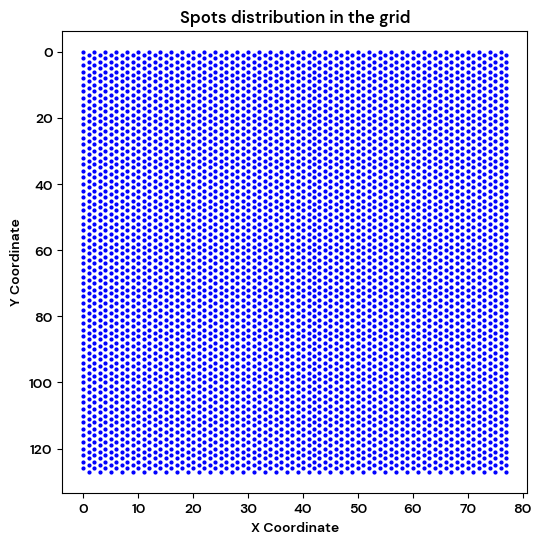

In [15]:
# Plot the spots
f = plt.figure(figsize=(6, 6))
plt.scatter(tissue_positions_list["array_row"], tissue_positions_list["array_col"], c='blue', s=4)
plt.gca().invert_yaxis()  # Invert y-axis to match image coordinates
plt.title("Spots distribution in the grid")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.show()
f.savefig("figures/visium_spots_distribution_in_grid.pdf")

In [16]:
# # Plot the spots
# f = plt.figure(figsize=(6, 6))
# plt.scatter(omni_whitelist["row_array"], omni_whitelist["col_array"], c='blue', s=4)
# plt.gca().invert_yaxis()  # Invert y-axis to match image coordinates
# plt.title("Spots distribution in the grid")
# plt.xlabel("X Coordinate")
# plt.ylabel("Y Coordinate")
# plt.show()
# f.savefig("figures/visium_spots_distribution_in_grid.pdf")

Now, let's merge the OMNI whitelist table and the one derived from the Loupe Browser manual image alignment based on the spots position in the grid. We'll have to leverage on the `row_array` and `col_array` columns.\
I'm going to name the table and the relative `.csv` file as `satac_fake_tissue_position_list`.

In [17]:
# satac_fake_tissue_position_list = satac_fake_coordinates.merge(omni_whitelist, how = "inner", 
#                                                                                left_on = ["row_array", "col_array"], 
#                                                                                right_on = ["row_array", "col_array"])
# barcodes = satac_fake_tissue_position_list.pop("barcode")
# satac_fake_tissue_position_list.insert(0, "barcode", barcodes)
# satac_fake_tissue_position_list

Now, let's visualise the spots that overlap the distribution of the spots overlapping the tissue in the space.

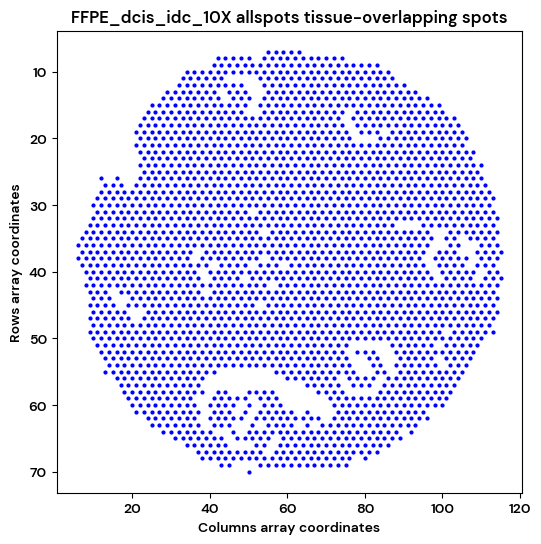

In [18]:
only_in_tissue = tissue_positions_list[tissue_positions_list["in_tissue"] == True] # for selecting only the spots in the tissue

# Plot the spots
f = plt.figure(figsize=(6, 6))
plt.scatter(only_in_tissue["array_col"], only_in_tissue["array_row"], c='blue', s=4)
plt.gca().invert_yaxis()  # Invert y-axis to match image coordinates
#plt.gca().invert_xaxis()
#plt.
plt.title(f"{SAMPLE} {COORDINATE_SYSTEM} tissue-overlapping spots")
plt.xlabel("Columns array coordinates")
plt.ylabel("Rows array coordinates")
plt.show()
f.savefig(f"figures/{SAMPLE}_{IMAGE_VERSION}_{COORDINATE_SYSTEM}_in_grid.pdf")

---

# 3. - Tiling of original WSI 
First of all, let's load the full resolution image and visualise the size.

In [19]:
# open the image without pixels limits and store the size (pixel, pixel)
Image.MAX_IMAGE_PIXELS = None
full_res_image = Image.open(IMAGE_PATH)
image_size = full_res_image.size
image_size

(27452, 25233)

Accordingly to this 10X Genomics [page](https://kb.10xgenomics.com/hc/en-us/articles/360035487572-What-is-the-spatial-resolution-and-configuration-of-the-capture-area-of-the-Visium-v1-Gene-Expression-Slide):
*The capture area is 6.5 x 6.5 mm. There are a total of 4992 total spots per capture area and each spot is 55 µm in diameter with a 100 µm center to center distance between spots.*

However, when looking in the **Scale Factors** [section](https://www.10xgenomics.com/support/software/space-ranger/latest/analysis/outputs/spatial-outputs#scale-factors) for Space Ranger Spatial Outputs, it's stated that:

`scalefactors_json.json`: The purpose of the file is to record the relative scales of the user-supplied image, the images in the spatial outs, and the Visium array. This file may contain the following fields:

-  [...]
-   `spot_diameter_fullres`: The number of pixels that span the diameter of a spot in the original, full-resolution image. This field is intended for visualization purposes, and can vary for different slide designs, ranging from **60-70 µm**. Spot diameters and spot positions are estimates. It is better to use the known pixel dimensions of a calibrated microscope rather than trying to infer pixel dimensions from the spot diameter.

So, we can't perform tiling in an automatic way.\
What I did was repeating the next steps until I found the best value for the spot diameter in a way that the 100 μm tiles wouldn't overlap. In particular, I've found that **68 μm** is the best compromise for not having tiles overlapping.

In the end, we'll perform tiling in two ways:
- at the **68 μm** spot level
- at the **100 μm** tile level

For doing so, we'll use the `crop_tile` function, which will crop the image based on the coordinates and the length of the tile (68 or 100 μm) in pixels.

As previously stated, for the 68μm-tiles, we can easily refer to the diameter in the `dia` column of the `satac_fake_tisse_positions_list` DataFrame as the value (`377.86462`) represents the number of pixels in the 68 μm spot.\
Being said that, thanks to an easy proportion, we can estimate the number of pixels for 100 μm.

In [20]:
SCALE_FACTOR_PATH
# Load the manual_alignment.json file
with open(SCALE_FACTOR_PATH, 'r') as f:
    visium_json = json.load(f)

visium_json.keys()

dict_keys(['tissue_hires_scalef', 'tissue_lowres_scalef', 'fiducial_diameter_fullres', 'spot_diameter_fullres'])

In [21]:
print(visium_json["spot_diameter_fullres"])

188.56998854645946


In [22]:
# 68 μm
spot_diameter = 68
scale_factor_spot_diameter = float(visium_json["spot_diameter_fullres"])
print("68μm-spot's diameter in pixels: ~", scale_factor_spot_diameter, "px")

# 100 μm
tile_length = 100
scale_factor_tile_length = (scale_factor_spot_diameter * tile_length) / spot_diameter
print("100μm-tile's size in pixels: ~", math.floor(scale_factor_tile_length), "px")

68μm-spot's diameter in pixels: ~ 188.56998854645946 px
100μm-tile's size in pixels: ~ 277 px


Once the convertion is done, let's define the working functions.

In [23]:
def correct_draw_tiles_on_wsi(wsi_image, coords_df, px_size, um_size, output_path=None):
    """
    Draws rectangles on the whole slide image (WSI) based on the spot coordinates.

    :param wsi_image: PIL Image object of the full-resolution WSI
    :param coords_df: DataFrame containing spot coordinates with 'pxl_col' and 'pxl_row'
    :param px_size: Size of each tile in pixels
    :param output_path: (Optional) Path to save the new WSI with drawn rectangles
    :return: Image with drawn rectangles
    """
    
    # Convert image to RGB if not already
    wsi_image = wsi_image.convert("RGB")
    draw = ImageDraw.Draw(wsi_image)

    for _, row in coords_df.iterrows():
        if row['in_tissue']:
            x_pxl, y_pxl = row["pxl_col"], row["pxl_row"]

            # Compute tile boundaries (same logic as crop_tile_visium)
            left = x_pxl - math.floor(px_size / 2)
            upper = y_pxl - math.floor(px_size / 2)
            right = x_pxl + math.floor(px_size / 2)
            lower = y_pxl + math.floor(px_size / 2)

            # Draw rectangle on WSI
            draw.rectangle([left, upper, right, lower], outline="red", width=20)

    # resizing the image for simplicity in loading step
    # defining the size of the image
    width_in_pixels = 2000
    height_in_pixels = round((wsi_image.size[1] * width_in_pixels / wsi_image.size[0]))
    new_size = width_in_pixels, height_in_pixels
    
    high_res_image = wsi_image.resize(new_size, Image.Resampling.LANCZOS)
    
    # save
    #temp_path = 
    if output_path:    
        high_res_image.save(os.path.join(output_path, f"correct_coordinates_for_cropping_{um_size}um.PNG"),"PNG")
        high_res_image.save(os.path.join(output_path, f"correct_coordinates_for_cropping_{um_size}um.pdf"), "PDF")
    else:    
        high_res_image.save(f"./figures/correct_coordinates_for_cropping_{um_size}um.PNG","PNG")
        high_res_image.save(f"./figures/correct_coordinates_for_cropping_{um_size}um.pdf", "PDF")


    return high_res_image

def tile_saver_visium(row, image, save_folder_path, tile_size, size_in_um):
    '''
    :param image: image path
    :param tile_coord: row of coordinates dataframe
    :param save_folder_path: path to folder for saving data
    :return: .jpg files
    
    This function simply takes the full resolution image, a single row of the coordinates file and returns the cropped tile with a specific file name that indicates if the spot was in the tissue or on the edge, the spot index in the coordinates dataframe, the barcode and the image short file name.
    '''
    if not row['in_tissue'] == True:
        return

    # Cropping the tile based on pixels
    tile = crop_tile_visium(image, row['pxl_col'], row['pxl_row'], tile_size)    # Now it's correct! -> it changes from Visium to sATAC
    
    # Eventually adding the directory for tile size in micrometers
    complete_path = os.path.join(save_folder_path, f"tiles_{size_in_um}")
    os.makedirs(complete_path, exist_ok=True)

    # Saving the tile
    # The format is: barcode_rowarray_colarray_sizeinmicrometersum.jpg
    file_name = f"{row['barcode']}_row{row['array_row']}_col{row['array_col']}_{size_in_um}um.jpg"
    tile.save(os.path.join(complete_path, file_name))
    


# From Maikee's GitLab repository
def crop_tile_visium(img, x_pxl, y_pxl, tile_size):
    """
    Function to create tiles of an image based on the coordinates of the spot center.
    """
    left = x_pxl - round(tile_size/2)
    upper = y_pxl - round(tile_size/2)
    right = x_pxl + round(tile_size/2)
    lower = y_pxl + round(tile_size/2)

    tile = img.crop((left, upper, right, lower))

    return tile

## 3.1 - 68 μm tiles

First of all, let's see if the functions are correct.

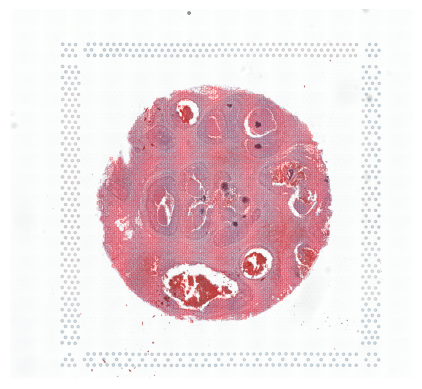

In [24]:
# Example usage
annotated_wsi = correct_draw_tiles_on_wsi(full_res_image, tissue_positions_list, scale_factor_spot_diameter, spot_diameter, output_tiles_path)
annotated_wsi = correct_draw_tiles_on_wsi(full_res_image, tissue_positions_list, scale_factor_spot_diameter, spot_diameter)

# Show the image with drawn tiles
img = mpimg.imread(os.path.join(output_tiles_path, [f for f in os.listdir(output_tiles_path) if f.endswith(f"{spot_diameter}um.PNG")][0]))
plt.axis("off")
imgplot = plt.imshow(img)


Then let's perfom the tiling.

In [25]:
print(f"Tiling for {spot_diameter} μm, {scale_factor_spot_diameter}x{scale_factor_spot_diameter} px tiles...\n")

tissue_positions_list.apply(tile_saver_visium, 
                                      axis = 1, 
                                      args = (full_res_image, output_tiles_path, scale_factor_spot_diameter, spot_diameter))

Tiling for 68 μm, 188.56998854645946x188.56998854645946 px tiles...



0       None
1       None
2       None
3       None
4       None
        ... 
4987    None
4988    None
4989    None
4990    None
4991    None
Length: 4992, dtype: object

## 3.2 - 100 μm tiles
Same for the 100 μm tiles.

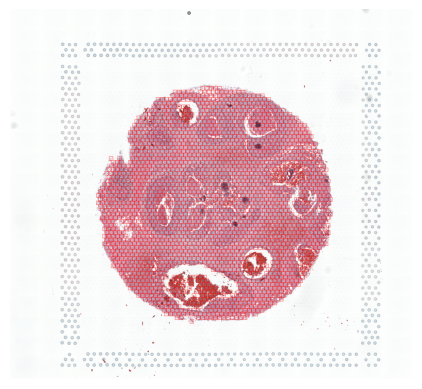

In [26]:
# Example usage
annotated_wsi = correct_draw_tiles_on_wsi(full_res_image, tissue_positions_list, scale_factor_tile_length, tile_length, output_tiles_path)
annotated_wsi = correct_draw_tiles_on_wsi(full_res_image, tissue_positions_list, scale_factor_tile_length, tile_length)

# Show the image with drawn tiles
img = mpimg.imread(os.path.join(output_tiles_path, [f for f in os.listdir(output_tiles_path) if f.endswith(f"{tile_length}um.PNG")][0]))
plt.axis("off")
imgplot = plt.imshow(img)

In [27]:
print(f"Tiling for {tile_length} μm, {scale_factor_tile_length}x{scale_factor_tile_length} px tiles...\n")

tissue_positions_list.apply(tile_saver_visium, 
                                      axis = 1, 
                                      args = (full_res_image, output_tiles_path, scale_factor_tile_length, tile_length))

Tiling for 100 μm, 277.3088066859698x277.3088066859698 px tiles...



0       None
1       None
2       None
3       None
4       None
        ... 
4987    None
4988    None
4989    None
4990    None
4991    None
Length: 4992, dtype: object

---
# 4. - Tiling of normalised WSI

As described in the `0_WSI_alignment_and_normalisation` folder, after image alignment I've also performed normalisation of the WSI.\
However, considering the size of the image, most of the normalisation methods that I've tried (all derived from the real application in the `2_image_normalisation` folder) didn't work, except for the HistomicsTK ones.\

Moreover, as stated at the end of the `0_WSI_normalisation_and_visualisation` notebook, we saw that the normalisation wasn't computed correctly for the Reinhard's methods, so I'll refer to *"Normalised WSIs"* as just the Macenko's ones.

So, let's proceed with tiling on these normalised WSIs.

## 4.1 - Importing the normalisation summary
The previously created `normalisation_summary.csv` file contains all the paths useful to the normalised WSIs, so we are going to use it to simplify the looping.

In [28]:
# Imports
normalisation_summary = pd.read_csv(f'{WSI_NORMALISATION_OUTPUT_PATH}normalisation_summary.csv', index_col=None)
normalisation_summary

,Normalization Method,Target,Mask,Path to folder
0,histomicsTK_macenko_nomasking,target_is_reference_full,False,histomicsTK_macenko_nomasking/target_is_refere...
1,histomicsTK_macenko_withmasking,target_is_reference_full,False,histomicsTK_macenko_withmasking/target_is_refe...
2,histomicsTK_macenko_withmasking,target_is_reference_full,True,histomicsTK_macenko_withmasking/target_is_refe...
3,histomicsTK_reinhard_nomasking,target_is_reference_full,False,histomicsTK_reinhard_nomasking/target_is_refer...
4,histomicsTK_reinhard_withmasking,target_is_reference_full,False,histomicsTK_reinhard_withmasking/target_is_ref...
5,histomicsTK_reinhard_withmasking,target_is_reference_full,True,histomicsTK_reinhard_withmasking/target_is_ref...
6,staintools_reinhard,target_is_reference_full,False,staintools_reinhard/target_is_reference_full/V...


Let's select ONLY the methods that worked (Macenko's ones) and Reinhard from StainTools package.

In [29]:
# code may vary in the future based on normalisation methods
normalised_wsis = normalisation_summary[
    ((normalisation_summary["Normalization Method"].str.contains("staintools_reinhard")) |  # Contains "macenko"
    (normalisation_summary["Normalization Method"].str.contains("macenko"))) &  # Contains "macenko"
    (normalisation_summary["Target"] == "target_is_reference_full") &         # Target is reference_full
    (normalisation_summary["Mask"] == False)                                 # Mask is False
]

# just the paths in a list
normalised_wsis_path_lists = [i for i in normalised_wsis.loc[:, "Path to folder"]]

normalised_wsis

,Normalization Method,Target,Mask,Path to folder
0,histomicsTK_macenko_nomasking,target_is_reference_full,False,histomicsTK_macenko_nomasking/target_is_refere...
1,histomicsTK_macenko_withmasking,target_is_reference_full,False,histomicsTK_macenko_withmasking/target_is_refe...
6,staintools_reinhard,target_is_reference_full,False,staintools_reinhard/target_is_reference_full/V...


In [30]:
# # 68 μm
# spot_diameter = 68
# scale_factor_spot_diameter = float(visium_json["spot_diameter_fullres"])
# print("55μm-spot's diameter in pixels: ~", scale_factor_spot_diameter, "px")

# # 100 μm
# tile_length = 100
# scale_factor_tile_length = (scale_factor_spot_diameter * tile_length) / spot_diameter
# print("100μm-tile's size in pixels: ~", math.floor(scale_factor_tile_length), "px")

Considering that the spots and the dimension of the images are the same of the original one, we can proceed with the tiling, but first of all we have to modify the saving function for make sure that also the name of normalisation method is saved in the tile name.

In [31]:
def tile_saver_visium_normalised(row, image, save_folder_path, normalisation_method, tile_size, size_in_um):
    '''
    :param image: image path
    :param tile_coord: row of coordinates dataframe
    :param save_folder_path: path to folder for saving data
    :return: .jpg files
    
    This function simply takes the full resolution image, a single row of the coordinates file and returns the cropped tile 
    with a specific file name that indicates the spot index in the coordinates dataframe, the barcode and the image short file name.
    '''
    if not row['in_tissue'] == True:
        return

    # Cropping the tile based on pixels
    tile = crop_tile_visium(image, row['pxl_col'], row['pxl_row'], tile_size)
    
    # Eventually adding the directory for tile size in micrometers
    complete_path = os.path.join(save_folder_path, f"tiles_{size_in_um}")
    os.makedirs(complete_path, exist_ok=True)
    
    # Saving the tile
    # The format is: barcode_rowarray_colarray_sizeinmicrometersum_fromWSI_normalisationmethod.jpg
    file_name = f"{row['barcode']}_row{row['array_row']}_col{row['array_col']}_{size_in_um}um_{normalisation_method}.jpg"
    tile.save(os.path.join(complete_path, file_name))

## 4.2 - 68 μm tiles


In [32]:
normalised_wsis_path_lists

['histomicsTK_macenko_nomasking/target_is_reference_full/Visium_FFPE_Human_Breast_Cancer_image_histomicsTK_macenko_nomasking.jpg',
 'histomicsTK_macenko_withmasking/target_is_reference_full/Visium_FFPE_Human_Breast_Cancer_image_histomicsTK_macenko_withmasking.jpg',
 'staintools_reinhard/target_is_reference_full/Visium_FFPE_Human_Breast_Cancer_image_st_reinhard_normalized.jpg']

In [33]:
for i in normalised_wsis_path_lists:
    
    # Setting all the variables for correct saving
    # folder name with nornmalisation meethod name and target
    normalisation_path_name = i.split("/")[0] + "_" + i.split("/")[1]    
    # normalisation name at the end of the tile name
    tile_end_name = f"fromWSI_{i.split('/')[0]}"
    # setting the saving path
    output_tiles_path = f"./output/{saving_sample}/tiling_output/{IMAGE_VERSION}_{COORDINATE_SYSTEM}_{normalisation_path_name}/"
    os.makedirs(output_tiles_path, exist_ok=True)
    # path to normalised WSI
    path_to_normalised_image = os.path.join(WSI_NORMALISATION_OUTPUT_PATH, i)
    
    # open the image without pixels limits
    Image.MAX_IMAGE_PIXELS = None
    temp_norm_wsi = Image.open(path_to_normalised_image)
    
    # initializing
    #scale_factor_spot_diameter = round(scale_factor_spot_diameter)
    print(f"Tiling for {spot_diameter} μm, {scale_factor_spot_diameter}x{scale_factor_spot_diameter} px tiles...\n")
    
    # Real call to the function
    tissue_positions_list.apply(tile_saver_visium_normalised, 
                                      axis = 1, 
                                      args = (temp_norm_wsi, output_tiles_path, tile_end_name, scale_factor_spot_diameter, spot_diameter))

Tiling for 68 μm, 188.56998854645946x188.56998854645946 px tiles...

Tiling for 68 μm, 188.56998854645946x188.56998854645946 px tiles...

Tiling for 68 μm, 188.56998854645946x188.56998854645946 px tiles...



## 4.2 - 100 μm tiles

In [34]:
for i in normalised_wsis_path_lists:
    
    # Setting all the variables for correct saving
    # folder name with nornmalisation meethod name and target
    normalisation_path_name = i.split("/")[0] + "_" + i.split("/")[1]    
    # normalisation name at the end of the tile name
    tile_end_name = f"fromWSI_{i.split('/')[0]}"
    # setting the saving path
    output_tiles_path = f"./output/{saving_sample}/tiling_output/{IMAGE_VERSION}_{COORDINATE_SYSTEM}_{normalisation_path_name}/"
    os.makedirs(output_tiles_path, exist_ok=True)
    # path to normalised WSI
    path_to_normalised_image = os.path.join(WSI_NORMALISATION_OUTPUT_PATH, i)
    
    # open the image without pixels limits
    Image.MAX_IMAGE_PIXELS = None
    temp_norm_wsi = Image.open(path_to_normalised_image)
    
    # initializing
    #scale_factor_tile_length = round(scale_factor_tile_length)
    print(f"Tiling for {tile_length} μm, {scale_factor_tile_length}x{scale_factor_tile_length} px tiles...\n")
    
    # Real call to the function
    tissue_positions_list.apply(tile_saver_visium_normalised, 
                                      axis = 1, 
                                      args = (temp_norm_wsi, output_tiles_path, tile_end_name, scale_factor_tile_length, tile_length))

Tiling for 100 μm, 277.3088066859698x277.3088066859698 px tiles...

Tiling for 100 μm, 277.3088066859698x277.3088066859698 px tiles...

Tiling for 100 μm, 277.3088066859698x277.3088066859698 px tiles...



---
**Saving the environment requirements**

In [35]:
# Save package versions to a .txt file
with open("requirements_for_tiling_env.txt", "w") as f:
    subprocess.run(["pip", "freeze"], stdout=f)